# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats as st
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1.1
Read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<img src="images/data.png" alt="drawing" width="800"/>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
print('Number of rows in the dataset: {}'.format(df.shape[0]))

Number of rows in the dataset: 294478


**c.** The number of unique users in the dataset.

In [4]:
print('The number of unique users in the dataset: {}'.format(df.user_id.nunique()))

The number of unique users in the dataset: 290584


**Remarks**:
The same user can enter the same web page more than once, as unique users < number of records in the dataset

**d.** The proportion of users converted.

In [5]:
print('The proportion of users converted: {}'.format(df.converted.value_counts(normalize=True)[1]))

The proportion of users converted: 0.11965919355605512


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

**Answer 1.1e:**

The intension of the data is that the control group uses only the old webpage, and that the treatment group use only the new page. We then will conduct A/B testing to compare which groups have the most conversions.

It does not make sense to have combinations control/new_page and treatment/old_page. 
These records needs to be removed for successful A/B testing

We should reject lines:

- control/new_page = 1928 records
- treatment/old_page = 1965 records

1928 + 1965 = 3893 total error records

**f.** Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**Answer 1f:**
There are no missing values
    

g. Extra step - How long was the experiment run for ?

In [8]:
df.timestamp = pd.to_datetime(df.timestamp)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [9]:
print('Experiment ran from {} to {}'.format(df.timestamp.min(), df.timestamp.max()))

Experiment ran from 2017-01-02 13:42:05.378582 to 2017-01-24 13:41:54.460509


In [10]:
print('Experiment ran for {}'.format(df.timestamp.max() - df.timestamp.min()))

Experiment ran for 21 days 23:59:49.081927


**Remarks:**
The experiment ran for only **21 days**, this seems like a very short time for this experiment

### 1.2  

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

**a.** Create a new dataset that meets the specifications.  Store your new dataframe in **df2**.

In [11]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query('(group == "control" & landing_page == "old_page") or (group == "treatment" & landing_page == "new_page")').copy()
len(df2)

290585

In [12]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [13]:
print('There are {} unique user_ids in df2'.format(df2.user_id.nunique()))

There are 290584 unique user_ids in df2


**Observation
:**
After the incorrect records was deleted, only 1 user visit the webpage more than once

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2[df2.duplicated('user_id', keep=False) == True]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**Answer 1.3b**

user_id '773192' is duplicated

**c.** Display the rows for the duplicate **user_id**? 

In 1.3b we can see rows 1899 and 2893 is causing the problems

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [15]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not
df2.drop_duplicates(['user_id'], inplace=True, keep='last')
len(df2)

290584

### 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [16]:
# overall conversion rate
p_population = df2.converted.mean()
print('Overall "converted" success rate in the population is {}'.format(round(p_population,4)))

Overall "converted" success rate in the population is 0.1196


**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control = df2.query('group == "control"')['converted'].mean()
print('Probability control group converted is {}'.format(round(p_control, 4)))

Probability control group converted is 0.1204


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment = df2.query('group == "treatment"')['converted'].mean()
print('Probability treatment group converted is {}'.format(round(p_treatment, 4)))

Probability treatment group converted is 0.1188


In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment - p_control
print('Actual difference between the conversion rates for the two groups is {}'.format(round(obs_diff,4)))

Actual difference between the conversion rates for the two groups is -0.0016


**d.** What is the probability that an individual received the new page?

In [20]:
round(df2.group.value_counts(normalize=True), 4)

treatment    0.5001
control      0.4999
Name: group, dtype: float64

There is a 50/50% chance an individual will receive either the control or treatment pages

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Your answer goes here.**

- Overall the conversion rate for all users is 11.96%
- Both the control and treatment group have very similar conversion rates of 12.04% vs 11.88% irrespectively
- On first glance the 2 groups have very similar behavior. The control group have a slighly higher conversion rate of 0.16%, which from practical perspective, is not significant.


**Next step:**
Is the 0.16% higher conversion rate of the control group due to chance, or is this 0.16% difference significant ? Let's bootstrap the sample to simulate the sample distribution of differences in proportions

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**Put your answer here.**

### Hypothesis: 

### $$H_0: p_{new} - p_{old} <= 0$$
### $$H_1: p_{new} - p_{old} > 0  @{\alpha} = 0.05 $$ 

In layman's terms:

- Null hypothesis: we assume the conversion rate of the old webpage to be the same or better than the new web page
- Alternative hypothesis: what we try to proof, in our case, the conversion rate for the new webpage is better

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = round(df2['converted'].mean(),4)
p_new

0.1196

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = p_new
round(p_old,4)

0.1196

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [23]:
n_new = len(df2.query('group == "treatment"'))
print('Number of individuals in the treatment group is {}'.format(n_new))

Number of individuals in the treatment group is 145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = len(df2.query('group == "control"'))
print('Number of individuals in the control group is {}'.format(n_old))

Number of individuals in the control group is 145274


**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [25]:
# Simulate a Sample for the treatment Group
df_treatment = df2.query('group == "treatment"')
new_page_converted = np.random.choice(df_treatment['converted'], size=n_new)
p_new_mean = new_page_converted.mean()
p_new_mean

0.11755557084853073

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
df_control = df2.query('group == "control"')
old_page_converted = np.random.choice(df_control['converted'], size=n_old)
p_old_mean = old_page_converted.mean()
p_old_mean

0.11913349945620001

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
sample_diff = p_new_mean - p_old_mean
sample_diff

-0.0015779286076692822


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
p_diffs = []
for _ in range(10000):
    p_new2 = np.random.choice([1, 0], size=n_new, replace=True, p=[p_new, 1-p_new])
    p_old2 = np.random.choice([1, 0], size=n_old, replace=True, p=[p_old, 1-p_old])
    p_new_mean = p_new2.mean()
    p_old_mean = p_old2.mean()
    p_diffs.append(p_new_mean-p_old_mean)

In [29]:
# convert to numpy array and calculate the mean
p_diffs = np.array(p_diffs)
print('Mean of sampling distribution is: {:.8f}'. format(p_diffs.mean()))

Mean of sampling distribution is: -0.00000890


**Observation:**

Actual difference in conversions from the observed data (-0.0016) is close to the test statistic 'difference in the converted probability' (-0013) of the sampling distribution, which is what we would expect under the *law of large numbers*.

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

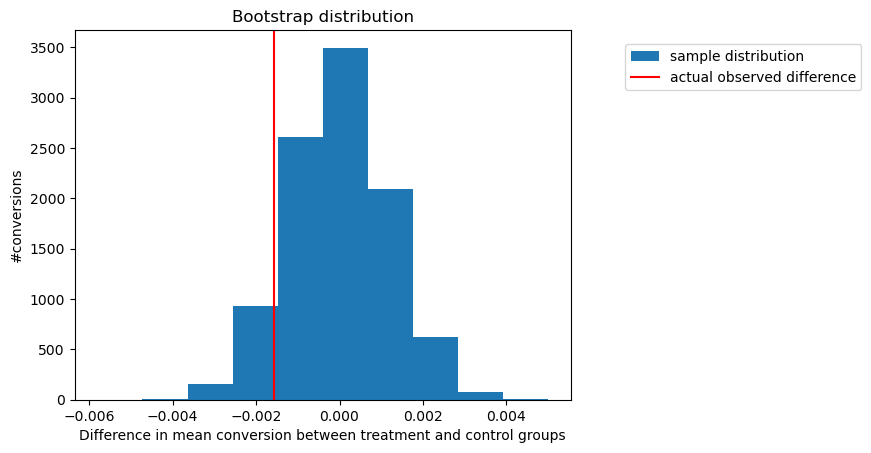

In [30]:
plt.hist(p_diffs, label='sample distribution')
plt.axvline(obs_diff, color='r', label='actual observed difference')
plt.xlabel('Difference in mean conversion between treatment and control groups')
plt.ylabel('#conversions')
plt.title('Bootstrap distribution')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [31]:
# extra step - pull the values for a 95% confidence interval
low = np.percentile(p_diffs, 2.5) 
high = np.percentile(p_diffs, 97.5)
print('95% confidence interval between {} and {}'.format(low, high))

95% confidence interval between -0.0023492700932936077 and 0.002324525137512031


In [32]:
# does the test statistic (difference in the converted probability) fall within the 95% confidence interval ?
min(low, high) < obs_diff < max(low, high)

True

The actual conversion difference lies within the 95% confidence interval of our sampling distribution, which is an indication what we should fail to reject the null.

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

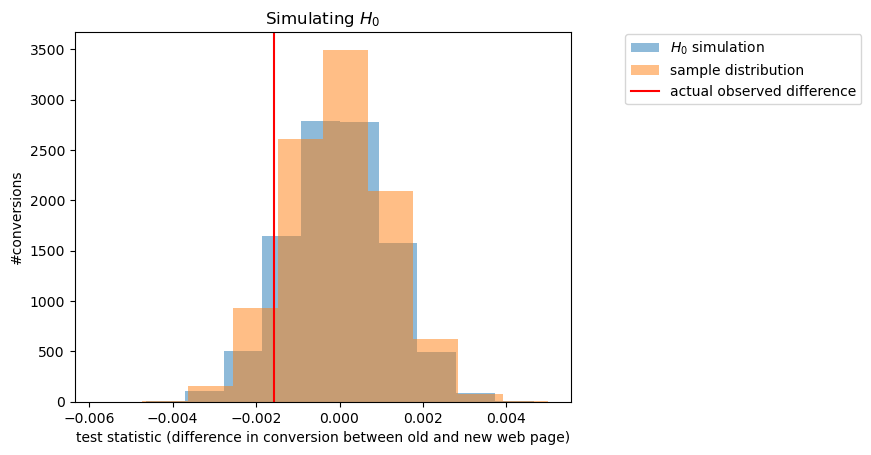

In [33]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals, alpha=0.5, label='$H_0$ simulation')
plt.hist(p_diffs, alpha=0.5, label='sample distribution')
plt.axvline(x=obs_diff,color='red', label='actual observed difference')
plt.xlabel('test statistic (difference in conversion between old and new web page)')
plt.ylabel('#conversions')
plt.title('Simulating $H_0$')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.9))
plt.show()

In [34]:
# Compute p-value
(null_vals > obs_diff).mean()

0.9025

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Put your answer here.**

In summary, in part **j**, we simulate what we expect the data *should* look like, if it came from the null and compare the result with the actual difference in conversion.

**Process**

The actual conversion rate for the control group, that lands only on the old web page, is 12.04%, and that of the treatment group, that lands only on the new web page is 11.88% There is an actual 0.16% difference in conversion rates between the 2 groups. Was this difference significant or just due by change ? 

We compute the probability of getting at least 0.16% difference in conversion rate, under the null hypothesis that the old web page is better or the same as the new page. We call this probability, the p_value.

We are using bootstrap sample distribution with a test statistic of 'difference in conversion rate' ($(p{'}_{new}$ - $p{'}_{old})$), to test the null hypothesis.

We know that the conversion rate differences of the sampling distribution will be normally distributed, under the central limit theorem. We simulute the null by building a normal distribution curve with mean the value closest to the alternative, but still within the null hypothesis, which in our case = 0. We use the standard deviation from our sampling distribution.

A test statistic is single number that can be computed from observed data and from data simulated under the null hypothesis. It serves as a basis of comparison between the two. 

The test statistic is used to compute the p_value, which calculates the probability that the old webpage have a higher conversion rate of 0.16% or more.

The p_value is the fraction of the simulated data under the null, for which the test statistic is at least as extreme as the actual difference in conversion rate. We calculate the proportion of null distribution that are greater than the actual difference observed. 


**Findings**

There is a 90% probability, that the old webpage will have at least a 0.16% higher conversion rate

As the p_value is far above the threshold of type I error rate alpha of 5%, the difference is not significant and we fail to reject the null hypothesis.

**Plot observations**

Standard distribution plots are generated to show the difference in sample distribution (orange), the simulated null (blue) and the actual difference in conversion rate (red).

We can observe:
- The red line (actual conversion rate) are slightly to the left of the mean of the null, which gives a high indication that the data came from the null. 
- As the alternative are expected to be *right_tailed*, we can observe a large area from the red line to the right of the null distribution (blue). We call this area the p-value.
- There is a high overlap between the null (blue) and distribution sample distribution (orange) which once again indicate it's highly likely that the data came from the null. Also notice the sample distribution are to the left of the mean of the null, which satisfy the '<' portion of the null.

**Additional thoughts:**

As it's very difficult to grasp the concept of p-values, see workbook 'simulating_alternative' in the same directory, where I simulated what the data and graphs will look like, if we need to reject the null hypotesis.

See below graph to illustrate the comparison. Notice how the p_value change when the actual observed difference changes! 

<img src="images/p_value.png" alt="drawing" width="1000"/>



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control"')['converted'].sum()
print('Number of conversions with the old page: {}'.format(convert_old))

# number of conversions with the new_page
convert_new =df2.query('group == "treatment"')['converted'].sum()
print('Number of conversions with the new page: {}'.format(convert_new))

# number of individuals who were shown the old_page (calculated in 2.2 above)
print('Number of individuals who were shown the old_page: {}'.format(n_old))

# number of individuals who received new_page (calculated in 2.2 above)
print('Number of individuals who received new_page: {}'.format(n_new))

# # Calculate the proportions for old and new pages
prop_old = convert_old / n_old
prop_new = convert_new / n_new
print('Proportions for old page is {}, Proportions for new page is: {}'.format(prop_old, prop_new))

Number of conversions with the old page: 17489
Number of conversions with the new page: 17264
Number of individuals who were shown the old_page: 145274
Number of individuals who received new_page: 145310
Proportions for old page is 0.1203863045004612, Proportions for new page is: 0.11880806551510564


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [36]:
# calculate z-score and p_value
count = [convert_new, convert_old]
nobs = [n_new, n_old]

z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='larger')
print('zscore: {}, p_value: {}'.format(round(z_score, 4), round(p_value, 4)))

zscore: -1.3109, p_value: 0.9051


In [37]:
# critical value at 95% confidence level (start)
# corresponding z-value that cuts of the right tail between success and reject area

critical_value = st.norm.ppf(.95)
print('The rejection region is {} to ∞'. format(round(critical_value, 3)))

The rejection region is 1.645 to ∞


In [38]:
# critical value for difference (differences that will enter the rejection zone)
sample_mean = null_vals.mean()
sample_std = null_vals.std()

critical_value_datapoint = sample_mean+(critical_value*sample_std)
print('The rejection region for each datapoint (difference in mean) is {} to ∞'. format(round(critical_value_datapoint, 4)))

The rejection region for each datapoint (difference in mean) is 0.002 to ∞


i.2 - how to calculate the zscore manually

In [39]:
# how to calculate the zscore manually
a = convert_old/n_old
b =convert_new/n_new
zscore = (b - a)/np.std(p_diffs)
zscore

-1.3203506446069995

i.3 - how to calculate the p_value using the zscore

In [40]:
# how to calculate the p_value using the zscore
p_val = 1 - st.norm.cdf(zscore)
p_val

0.9066410130341932

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Put your answer here.**

The **p_value**, 0.905, computed using the build-in function of statsmodels, gives the same p_value that we calculated in step **j**. 
The p_value is larger that the 5% significance level we specified, so once again, we fail to reject $H_0$


**Another way to make a decision is to compare z_scores**

Our new test statistic: reject null if $Z_{score}$ > $Z_{\alpha}$

The build-in function first calculate a z-statistic or z-score.
The $Z_{score}$ is a formula to calculate how many standard deviations a data point are from the mean. In our case, the data point is the mean difference in conversion rate ($(p{'}_{new}-p{'}_{old})$) (our test statistic in previous section)

The z_score is used to calculate the p_value, which represent the area under the curve related to the specific z-score. (As illustration how to understand the relationship between the z-test statistics and p_value see simulatation in i.2 and i.3 above how p_value can be calculated from a z-score)

It's given that $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval, has a z-score of 1.645 for one-tailed tests. It's also known as the rejection region and establish the point on the distribution that divide the reject/success area
<img src="images/critical_value.png" alt="drawing" width="500"/>

For a right-tailed test, we fail to reject the null as $Z_{score}$ of -1.31 < $Z_{\alpha}$ of 1.6449

We thus get the same results in a manual vs built-in approach, we fail to reject the mean

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**

Logistics Regression, as we predict a categorial response.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [41]:
df3 = pd.get_dummies(data=df2, columns=['group'], drop_first=True)
df3['intercept'] = 1
df3.head()

,user_id,timestamp,landing_page,converted,group_treatment,intercept
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1


In [42]:
df3.rename(columns={'group_treatment': 'ab_page'}, inplace=True)
df3.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [43]:
logit1 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results_logit1 = logit1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [44]:
results_logit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 06 Oct 2023   Pseudo R-squ.:               8.077e-06
Time:                        07:15:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [45]:
# get coefficient value for ab_page
1/np.exp(results_logit1.params)

intercept    7.306593
ab_page      1.015102
dtype: float64

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Put your answer here.**

- In part III, p_value of ab_page is 0.19, compared to 0.905 in the Part II. The p_values are different because the null and alternative hypothesis are different

>#### Hypothesis in part II, which is right tailed
>##### $$H_0: p_{new} - p_{old} <= 0$$
>##### $$H_1: p_{new} - p_{old} > 0 $$ 

>#### Hypothesis in part III which are two-tailed
>##### $$H_0: p_{new} - p_{old} = 0$$
>##### $$H_1: p_{new} - p_{old} \neq 0 $$ 

- In both part II and III, the p_value > type I error rate of 0.05, so in both cases we fail reject the null hypothesis as the difference is not significant

- Interpretation of ab_page coefficient:
  - conversion rate will decrease 1.015 times if indivuals will use the new web page

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Put your answer here.**

It's a good idea to introduce more factors to eliminate and identify possible bias, and improve predictive power. 

Factors that might influence conversion are the time duration an experiment was run for. Our experient ran for only 21 days which seems short. This can cause issues, as it might not cover for example mid-month vs month-end peaks. 

We also need to understand more about each individual, their country, language, financial situation, gender and so forth.

**Possible disadvantages:**
- we need to make sure there are no correlation between new factors introduced, as this can produce wrong results. X variables need to be independend with no relationships between each other
- adding interactions between X variables to the model, makes coefficients no longer easy interpretable. We will get better predictions, but it's not easy to explain anymore.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [46]:
# Read the countries.csv
df_countries = pd.read_csv('data/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Join df2 dataframe with countries
df_merged = df3.merge(df_countries, how='inner', on='user_id', indicator=True, validate='one_to_one')
df_merged.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept,country,_merge
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1,US,both
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1,US,both
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US,both
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US,both
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1,US,both


In [48]:
# check if records were joined correctly
df_merged['_merge'].unique()

['both']
Categories (3, object): ['left_only', 'right_only', 'both']

In [49]:
# check that we the same records before and after the join
df_merged.shape, df_merged.shape

((290584, 8), (290584, 8))

In [50]:
# make sure country have no null values
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       290584 non-null  int64         
 1   timestamp     290584 non-null  datetime64[ns]
 2   landing_page  290584 non-null  object        
 3   converted     290584 non-null  int64         
 4   ab_page       290584 non-null  uint8         
 5   intercept     290584 non-null  int64         
 6   country       290584 non-null  object        
 7   _merge        290584 non-null  category      
dtypes: category(1), datetime64[ns](1), int64(3), object(2), uint8(1)
memory usage: 16.1+ MB


In [51]:
# In which countries did we run experiments ?
df_merged.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [52]:
# What is the web traffic in each country ?
df_merged.groupby(['country']).converted.value_counts().unstack()

converted,0,1
country,,
CA,12827,1672
UK,63727,8739
US,179277,24342


Notice that the US has a lot more web traffic and conversions than other countries

In [53]:
# what is conversion rate per country ?
df_conversion = df_merged.groupby(['country']).converted.value_counts(normalize=True).unstack()
df_conversion

converted,0,1
country,,
CA,0.884682,0.115318
UK,0.879406,0.120594
US,0.880453,0.119547


In [54]:
# What is the probability that an individual received the new page in CA ?
df_merged.query('country == "CA"').landing_page.value_counts(normalize=True)

new_page    0.503552
old_page    0.496448
Name: landing_page, dtype: float64

In [55]:
# What is the probability that an individual received the new page in UK ?
df_merged.query('country == "UK"').landing_page.value_counts(normalize=True)

old_page    0.501753
new_page    0.498247
Name: landing_page, dtype: float64

In [56]:
# What is the probability that an individual received the new page in US ?
df_merged.query('country == "US"').landing_page.value_counts(normalize=True)

new_page    0.500459
old_page    0.499541
Name: landing_page, dtype: float64

**Observations:**

- Even though US has a lot more traffic, countries have similar conversion rates of around 12%
- UK have the highest conversion rate at 12%, which is 0.5% higher conversion than Canada
- By introducing country, we still observe a 50/50% probability that an individual will receive either the old or new webpages within a country. 
- Countries have similar conversion rates
- Overall the US have a lot more web traffic

In [57]:
# Create dummy variables for country columns
df_merged = pd.get_dummies(data=df_merged, columns=['country'])
df_merged.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept,_merge,country_CA,country_UK,country_US
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1,both,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1,both,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,both,0,0,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,both,0,0,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1,both,0,0,1


In [58]:
# Fit your model using just country to predict conversion
# set country CA as baseline, as it has the lowest observed conversion rate
logit2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'country_UK', 'country_US']])
results_logit2 = logit2.fit()
results_logit2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 06 Oct 2023   Pseudo R-squ.:               1.521e-05
Time:                        07:15:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [59]:
# create interactions between page and country
df_merged['US_ab_page'] = df_merged['country_US']*df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['country_UK']*df_merged['ab_page']

In [60]:
# Fit your model, and summarize the results
# set country CA as baseline, as it has the lowest observed conversion rate
logit3 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'country_UK', 'country_US', 'UK_ab_page', 'US_ab_page']])
results_logit3 = logit3.fit()
results_logit3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 06 Oct 2023   Pseudo R-squ.:               3.482e-05
Time:                        07:15:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
country_UK     0.0118      0.040      0.296      0.767      -0.066       0.090
country_US     0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

In [61]:
# compute exponential of coefficients, and also compute the reciprocal as all coefficients are negative
np.exp(results_logit3.params)

intercept     0.134794
ab_page       0.934776
country_UK    1.011854
country_US    1.017682
UK_ab_page    1.081428
US_ab_page    1.048001
dtype: float64

>**Put your conclusion answer here.**

- all p_values are greater than type I error rate of 5%, therefore the differences between new and old page conversions are not significant and we fail to reject the null hypothesis for the regression model 
- all country related coeficients are around 1, which means compared to each other and baseline of Canada, they have an equal impact on conversion between old vs new web page. 
- notice that country UK have the highest p_value of 76.7% and a slightly higher coefficient. The UK thus have a slightly higher conversion rate than the other countries, which confirm the summary statistics above.
- the negative coefficent of ab_page indicate that the conversion rate decrease for the treatment group compared to the control group as baseline. Conversion will decrease 0.93 times when using the new page.

We do not have any evidence, to suggest that the convertion between old and new page is significantly different between country and which landing page each individual gets.

Think about to extend the duration of the experiment for 21 days to 2 months.

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!



<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

# REFERENCES:

- [How to find critical Z value (Z alpha](https://www.youtube.com/watch?v=BVMHQWZgGF4)
- [How to interpret p_value](https://knowledge.udacity.com/questions/919986)
- An introduction to Statistics with Python by Thomas Haslwanter
- Analyze_ab_test_results_notebook](https://knowledge.udacity.com/questions/669807)
- [Comparison of Two Population Means- Large, Independent Samples](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples)
- [What is a z-test ?](https://www.investopedia.com/terms/z/z-test.asp)
- [Hypothesis testing in python](https://campus.datacamp.com/courses/hypothesis-testing-in-python/)

In [64]:
# convert notebook to html
import os

os.system('jupyter nbconvert --to html Analyze_ab_test_results_notebook.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Analyze_ab_test_results_notebook.ipynb to html
[NbConvertApp] Writing 852284 bytes to Analyze_ab_test_results_notebook.html


0

#### Additional links provided by Udacity

<span style="color: red;">YOUR TEXT</span>

- [debugging toolkit](https://jakevdp.github.io/PythonDataScienceHandbook/01.06-errors-and-debugging.html)
- [markdown](https://docs.github.com/en/get-started/writing-on-github/getting-started-with-writing-and-formatting-on-github/basic-writing-and-formatting-syntax)
- [VIP](https://etav.github.io/python/vif_factor_python.html)